In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f

In [97]:
# Get the data from the txt file which contains tab separated values
data = pd.read_csv('data/Raw Data_GeneSpring.txt', sep='\t')

# Remove rows with missing probe name or expression values, or missing gene symbol
# i.e, remove all rows which are missing any value in the first 50 columns
data = data.dropna(subset=data.columns[0:50], how='all')
data

,ProbeName,GSM1149106_M_Ns3.txt:gProcessedSignal(normalized),GSM1149107_M_Ns4.txt:gProcessedSignal(normalized),GSM1149108_M_Ns5.txt:gProcessedSignal(normalized),GSM1149109_M_Ns6.txt:gProcessedSignal(normalized),GSM1149110_M_Ns7.txt:gProcessedSignal(normalized),GSM1149111_M_Ns8.txt:gProcessedSignal(normalized),GSM1149112_M_Ns9.txt:gProcessedSignal(normalized),GSM1149113_M_Ns10.txt:gProcessedSignal(normalized),GSM1149114_M_Ns11.txt:gProcessedSignal(normalized),...,GSM1149147_F_Sm6.txt:gProcessedSignal(normalized),GSM1149148_F_Sm7.txt:gProcessedSignal(normalized),GSM1149149_F_Sm8.txt:gProcessedSignal(normalized),GSM1149150_F_Sm9.txt:gProcessedSignal(normalized),GSM1149151_F_Sm10.txt:gProcessedSignal(normalized),GSM1149152_F_Sm11.txt:gProcessedSignal(normalized),GSM1149153_F_Sm12.txt:gProcessedSignal(normalized),GeneSymbol,EntrezGeneID,Go
0,GE_BrightCorner,17.288560,18.103434,18.280110,17.883734,17.879555,17.340961,16.226210,16.203045,15.940904,...,16.039999,15.783204,14.843888,15.553449,15.912829,15.604271,16.120403,NaN,NaN,NaN
1,DarkCorner,2.172766,0.075925,0.232402,0.052573,0.483300,0.240482,0.327676,0.041980,0.015175,...,0.232663,0.023183,0.104347,0.055785,0.141535,0.113465,0.592137,NaN,NaN,NaN
2,A_24_P66027,11.954556,11.681619,11.831579,12.262896,11.233925,11.722222,11.582652,13.039122,12.615288,...,12.446932,12.315217,11.945836,11.924950,13.129469,12.378983,13.259206,APOBEC3B,9582.0,GO:0051607|GO:0047844|GO:0045087|GO:0008152|GO...
3,A_32_P77178,6.224496,6.963845,7.096990,7.319873,6.611215,6.760409,7.810502,8.377619,8.169108,...,7.813999,7.763040,7.712591,7.165883,8.364161,6.885972,9.458718,NaN,NaN,NaN
4,A_23_P212522,9.328137,9.164498,8.934509,9.166321,9.175541,8.810351,10.665818,10.681737,10.359045,...,10.240832,9.757538,9.847317,9.931273,10.160020,10.282162,11.035402,ATP11B,23200.0,GO:0005515|GO:0000287|GO:0005794|GO:0005886|GO...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41088,A_32_P38745,6.537273,6.243802,6.775369,7.147527,7.168765,6.806569,7.816844,8.446837,8.596057,...,7.342443,7.565965,7.628784,7.985845,8.497463,7.420097,9.618679,LOC101930246,101930246.0,NaN
41089,A_24_P246406,5.328301,5.540808,5.654654,5.438310,5.738548,5.385865,7.805837,6.947449,7.134393,...,7.115325,6.679066,6.913514,7.040463,6.962923,6.931123,7.478705,FAM69A,388650.0,GO:0005789|GO:0016021
41090,A_23_P5757,9.898471,10.378258,10.279259,10.104904,10.506216,10.135717,12.040487,11.578827,11.465943,...,11.670427,11.496683,11.132303,11.004814,11.290635,11.079154,12.066488,TPRKB,51002.0,GO:0005515|GO:0005737|GO:0019901|GO:0005634|GO...
41091,A_24_P926284,1.449114,1.413527,0.000000,0.000000,0.852284,0.000000,4.320505,2.000453,0.000000,...,0.000000,0.000000,0.005804,0.633679,2.002664,0.000000,0.000000,OFCC1,266553.0,GO:0005515


In [98]:
@np.vectorize
def smart_ratio(x: float, y: float) -> float:
    if x == y:
        return 1
    if y == 0:
        return np.infty
    return x/y

In [99]:
def multi_way_anova(observations: np.array, groups, effect_vectors_null: list[list[int]], effect_vectors_alternate: list[list[int]], rank_null=None, rank_alternate=None) -> float:
    '''
    Performs multi-way ANOVA test on the given observations (target variables), returns the p-value.

    Effect vector of a data-point belonging to group C is a binary vector v such that mu_C = v^T (mu_f1,...,mu_fn).
    
    Parameters:-
        data: matrix with each column being observations of one instance of a group
        groups: array containing lists where all instances of group i occur in group[i]
        effect_vectors_null/effect_vectors_alternate: matrix containg effect vectors under null/alternate hypothesis of defferent groups as rows
        observations: The observations (samples from the distribution under question in the form of a column vector)
    
    User must ensure that the effect matrices satisfy necessary conditions:- 
    rank(effect_matrix_null) <= rank(effect_matrix_alternate)
    '''

    # Make effect matrices
    num_groups = len(groups)
    group_sizes = [len(group) for group in groups]

    effect_matrix_null = np.array(sum(([effect_vector] * group_size for effect_vector, group_size in zip(effect_vectors_null, group_sizes)), []), dtype=int)
    effect_matrix_alternate = np.array(sum(([effect_vector] * group_size for effect_vector, group_size in zip(effect_vectors_alternate, group_sizes)), []), dtype=int)

    effect_matrix_null_T = effect_matrix_null.T
    effect_matrix_alternate_T = effect_matrix_alternate.T

    # Compute dimensions
    num_instances = observations.shape[1]
    num_observables = observations.shape[0]

    if rank_null is None:
        rank_null = np.linalg.matrix_rank(effect_matrix_null)
    if rank_alternate is None:
        rank_alternate = np.linalg.matrix_rank(effect_matrix_alternate)


    # Compute the relavant sums of squared errors and degrees of freedom
    observations_T = observations.T

    # Numerator, X^T (I - N(N^T N)^dagger N^T) X, N = effect_matrix_null
    sum_squared_errors_null = np.einsum('ij,jk,ki->i', observations, np.eye(num_instances) - effect_matrix_null @ np.linalg.pinv(effect_matrix_null_T @ effect_matrix_null) @ effect_matrix_null_T, observations_T)
    degrees_freedom_null = rank_alternate - rank_null

    # Denominator, X^T (I - D(D^T D)^dagger D^T) X, D = effect_matrix_alternate
    sum_squared_errors_alternate = np.einsum('ij,jk,ki->i', observations, np.eye(num_instances) - effect_matrix_alternate @ np.linalg.pinv(effect_matrix_alternate_T @ effect_matrix_alternate) @ effect_matrix_alternate_T, observations_T)
    degrees_freedom_alternate = num_instances - rank_alternate

    # Compute the F-statistics f_stat = (dof_d/dof_n)((num)/(den) - 1)
    F_statistics = smart_ratio(degrees_freedom_alternate, degrees_freedom_null) * (smart_ratio(sum_squared_errors_null, sum_squared_errors_alternate) - 1)
    
    # return p-values
    p_val = f(degrees_freedom_null, degrees_freedom_alternate).sf
    return p_val(F_statistics)

In [100]:
# Extract the observations matrix from the data
# Find the groups and their effect vectors for null and alternate hypothesis

# There are twelve columns for each of the four groups side-by-side, starting from index 1
observations = np.array(data.iloc[:, 1:4*12+1], dtype=float)
groups = [list(range(12*i, 12*(i + 1))) for i in range(4)]

# We fix and order the features as (is_male, is_female, is_smoker, is_non_smoker) and group order as (male non-smoker, male smoker, female non-smoker, female-smoker)

# Null hypothesis: The effects of gender and smoking are additive
# effect vectors for
#   male non-smoker = (1, 0, 0, 1)
#   male smoker = (1, 0, 1, 0)
#   female non-smoker = (0, 1, 0, 1)
#   female smoker = (0, 1, 1, 0)

effect_vectors_null =[[1, 0, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [0, 1, 1, 0]]

# Alternate hypothesis: The effects of gender and smoking are arbitrary
# We fix and order the features as (male_non_smoker, male_smoker, female_non_smoker, female_smoker)
# effect vectors for
#   male non-smoker = (1, 0, 0, 0)
#   male smoker = (0, 1, 0, 0)
#   female non-smoker = (0, 0, 1, 0)
#   female smoker = (0, 0, 0, 1)

effect_vectors_alternate = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

In [101]:
# Obtain p_values after performing 2-way ANOVA
p_values = multi_way_anova(observations, groups, effect_vectors_null, effect_vectors_alternate, rank_null=3, rank_alternate=4)

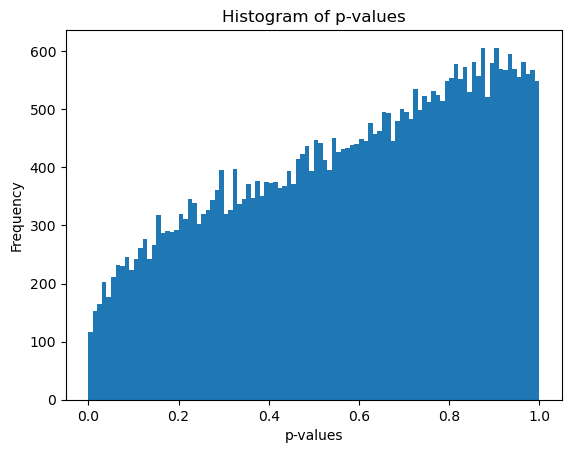

In [102]:
# Plot a histogram of the p-values
plt.hist(p_values, bins=100)
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of p-values')
plt.show()

In [103]:
# add the p-values to the data
data['p_value'] = p_values

# there can be multiple probe for the same gene, we take the minimum p-value for each gene
# Group the data sucht that each gene_symbol has only one row with the minimum p-value
p_values_grouped = data.groupby('GeneSymbol')['p_value'].min()
p_values_grouped

GeneSymbol
A1BG            0.895098
A1BG-AS1        0.343703
A1CF            0.169706
A2M             0.745894
A2ML1           0.484495
                  ...   
lnc-ZNF207-1    0.953656
lnc-ZNF236-1    0.878405
lnc-ZNF32-4     0.688449
lnc-ZNF382-1    0.123307
lnc-ZSWIM7-1    0.730260
Name: p_value, Length: 20356, dtype: float64

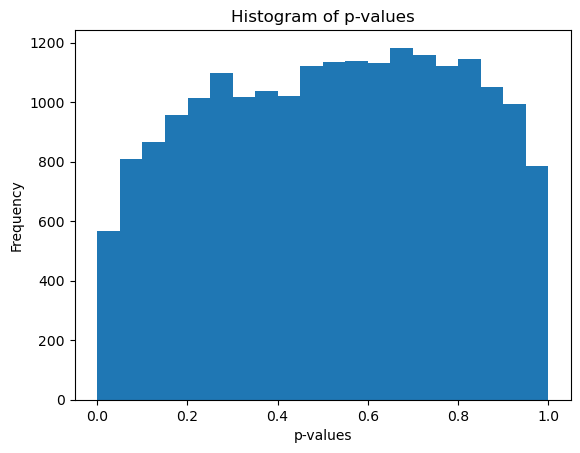

In [106]:
# Plot a histogram of the grouped p-values
plt.hist(p_values_grouped, bins=20)
plt.xlabel('p-values')
plt.ylabel('Frequency')
plt.title('Histogram of p-values')
plt.show()